 This notebook contains tests for the GLM beta parameter. From the meeting with Dario, Tiago and Yulin on Dec 11 2023 we have:
 
summarising conclusions from the discussion: </br>
checking eg log likelihood ratio change at each iteration to decide when model has converged </br>
including beta in regularsation</br>
regularisation to encourage sparseness of parameters </br>
spike history </br>
""Vm"": filtering PAG spikes with some kernel that looks like: ramp before spike (like, eg 10ms), steep and rapid decrease (like, 2ms) after spike, as a substitute for spike history </br>

In [1]:
import numpy as np
from glm import BernoulliGLMPyTorch
import pandas as pd

from utils import *

import torch
import torch.nn as nn
import torch.distributions as dist
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
sim_data_path = './sim/save/pagsim_w_stimuli/'
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]
presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
presyn_smooth = np.load(sim_data_path+'presyn_exp_smooth.npy')
bin_size = 0.001
n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000
# load actual connecticity: shape (n_brain_region * n_PAG * n_connections)
conns = np.concatenate([np.nan_to_num(np.load(f'{sim_data_path}connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0).T[None,:] * 1e9 for brain_region in brain_regions])

_range = 200 #ms
_random_start = np.random.randint(100000-_range)

### Test 1: fix beta (on 1 PAG , exp filtering)

In [3]:
n_PAG_to_use = 1 # specify how many PAG neurons to learn

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-14 16:00:49.659 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 44.35333333333333 Hz.


In [4]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

Number of PAG spikes in the training set:  13379.0
Number of PAG spikes in the test set:  4301.0


In [5]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs=['weights_within_group'],
    reg_params=1,
    ).to(device)

glm.linear.bias.data = torch.tensor([-100.]).to(device)
glm.linear.bias.requires_grad = False

glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_beta=-100.pth'))

glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_beta=-100.pth')

2023-12-14 14:29:11.330 | DEBUG    | glm:fit:308 - Training GLM with PyTorch. Initial log like: -183948.5, inital loss: 186135.5625
2023-12-14 14:29:39.374 | DEBUG    | glm:fit:332 - Step 2000. Log like: -181262.15625,  loss: 181982.0
2023-12-14 14:30:04.354 | DEBUG    | glm:fit:332 - Step 4000. Log like: -181262.234375,  loss: 181981.71875
2023-12-14 14:30:29.227 | DEBUG    | glm:fit:332 - Step 6000. Log like: -181262.234375,  loss: 181981.71875
2023-12-14 14:30:54.476 | DEBUG    | glm:fit:332 - Step 8000. Log like: -181262.25,  loss: 181981.734375


KeyboardInterrupt: 

In [6]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-100.]
y-intercept: [0.]


C:\Users\daniel\AppData\Local\Temp\ipykernel_13332\3377457532.py:3: RuntimeWarning: overflow encountered in exp
  print('y-intercept:', 1/(1+np.exp(-glm_b)))


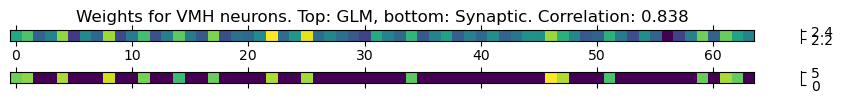

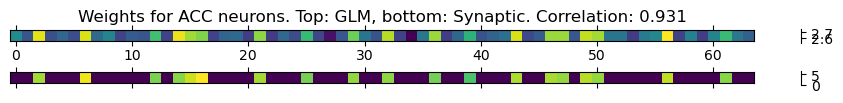

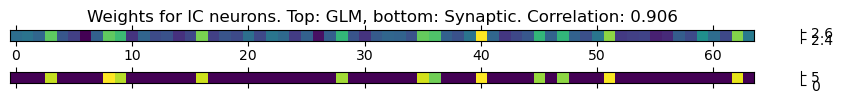

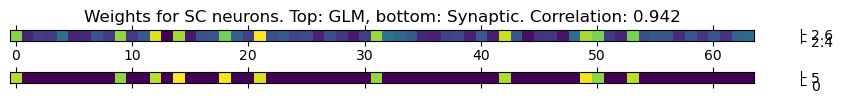

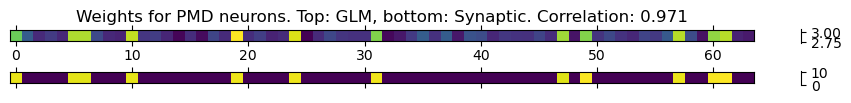

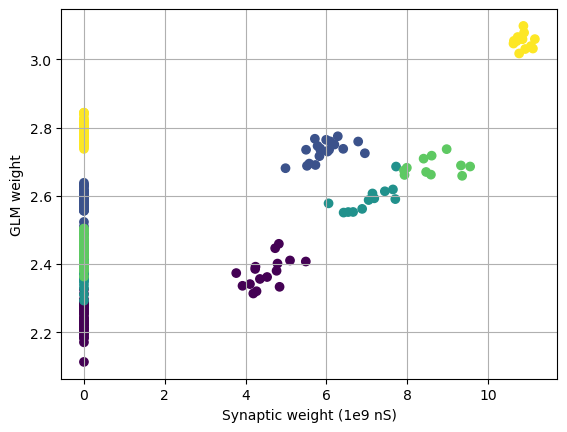

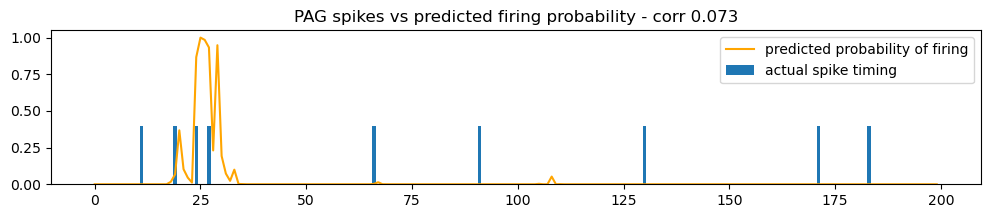

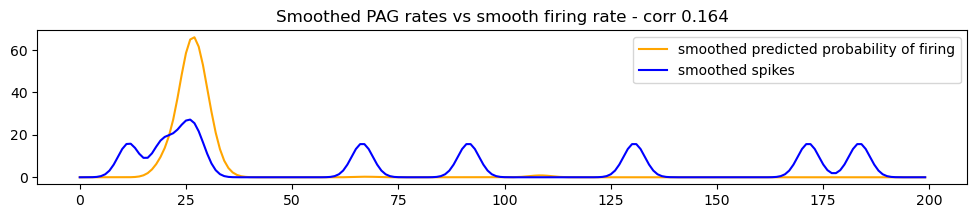

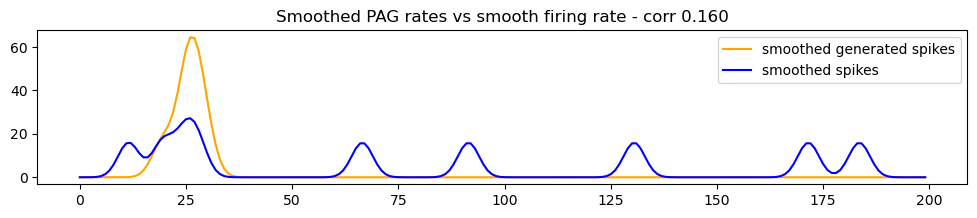

In [7]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 2.1 : Add regularisation term on beta
beta regularisation: 1 * beta**2 + n * beta ** (-3)

In [36]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group', 'beta'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100]),
                'beta':np.array([1,1,3,2])
               },
    ).to(device)


glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=2,3.pth'))

# glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.9999)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_betareg=2,3.pth')
with torch.no_grad():
    print(glm.calc_log_likelihood_w_reg(X_train.T, y_train.T, return_components=True))

(tensor(53289., device='cuda:0'), tensor([938.9883,   0.0000,  79.0116], device='cuda:0'))


In [37]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [0.11250152]
y-intercept: [0.5280958]


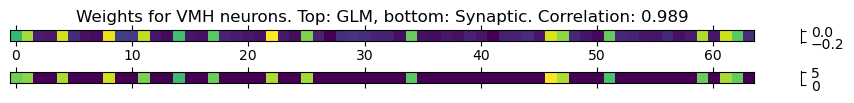

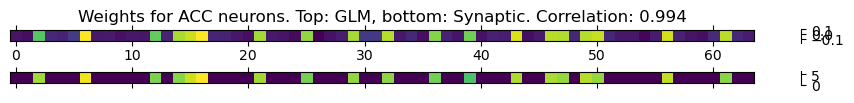

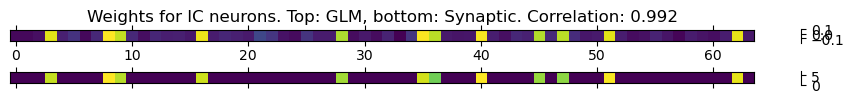

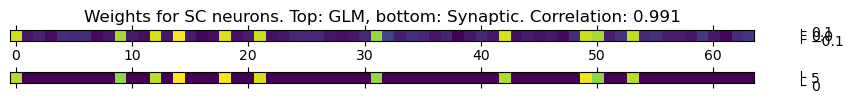

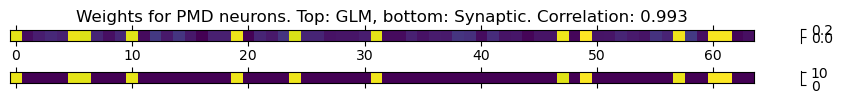

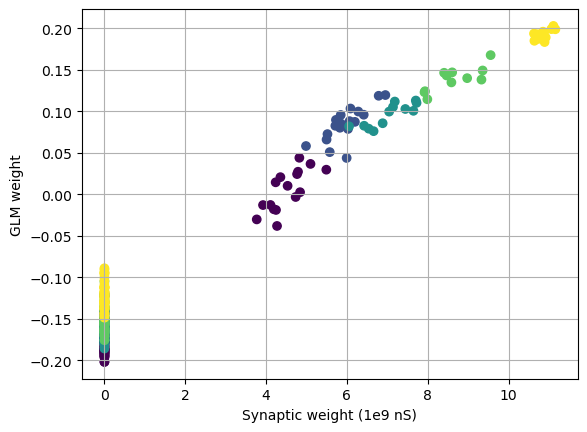

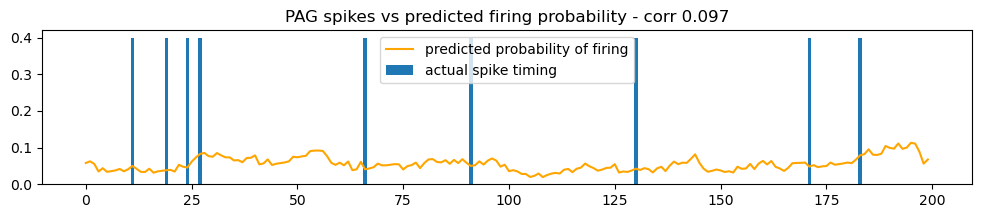

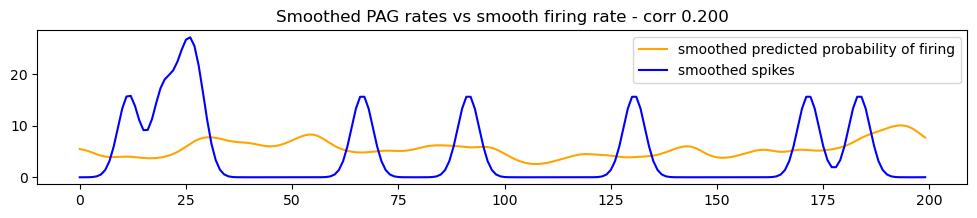

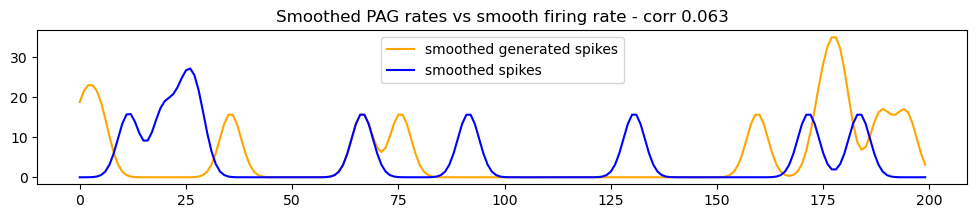

In [38]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 2.2 : Add regularisation term on beta
beta regularisation: 1 * beta**4 + n * beta ** (-5)

In [40]:

glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group', 'beta'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100]),
                'beta':np.array([1,1,5,4])
               },
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth'))

glm.fit(X_train.T, y_train.T, n_iter=30000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth')

2023-12-14 15:17:38.315 | DEBUG    | __main__:fit:126 - Training GLM with PyTorch. Initial log like: 205868.140625, loss 1095107.0, of which regs [5.6370726, 0.0, 889233.2] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:18:09.365 | DEBUG    | __main__:fit:153 - Step 1500. Log like: 54194.671875, loss 58195.28125, of which regs [450.5014, 0.0, 3550.1067] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:18:40.940 | DEBUG    | __main__:fit:153 - Step 3000. Log like: 53363.9453125, loss 55871.16796875, of which regs [931.5413, 0.0, 1575.6799] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:19:10.656 | DEBUG    | __main__:fit:153 - Step 4500. Log like: 53382.0859375, loss 55231.234375, of which regs [944.67896, 0.0, 904.47046] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:19:40.795 | DEBUG    | __main__:fit:153 - Step 6000. Log like: 53411.7578125, loss 54930.40234375, of which regs [946.5571, 0.0, 572.086] respectively f

In [41]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [0.30739185]
y-intercept: [0.5762485]


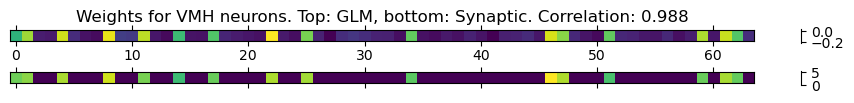

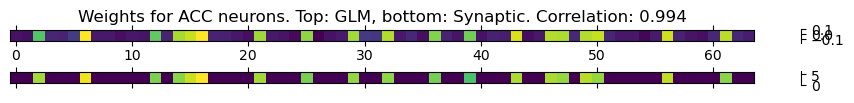

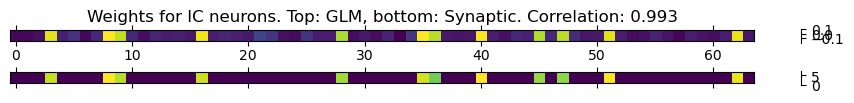

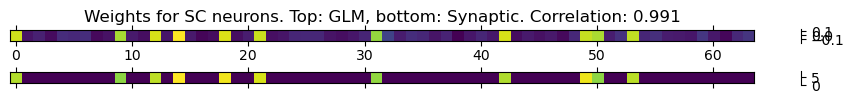

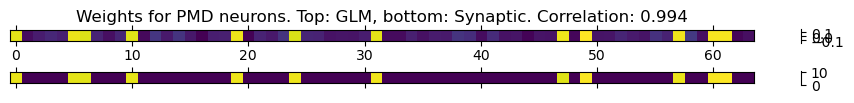

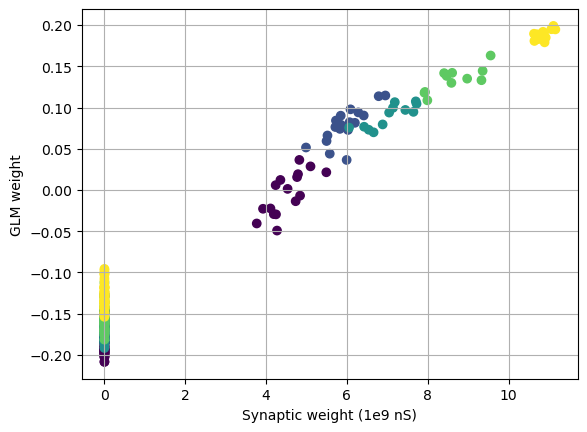

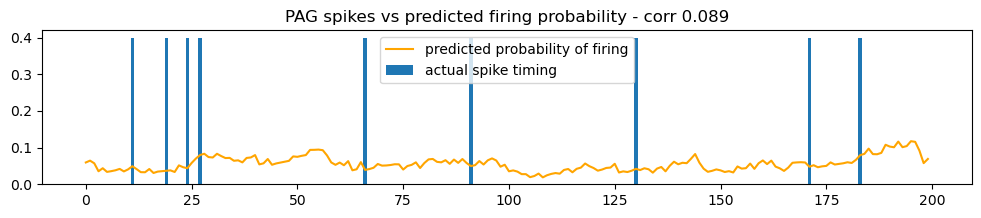

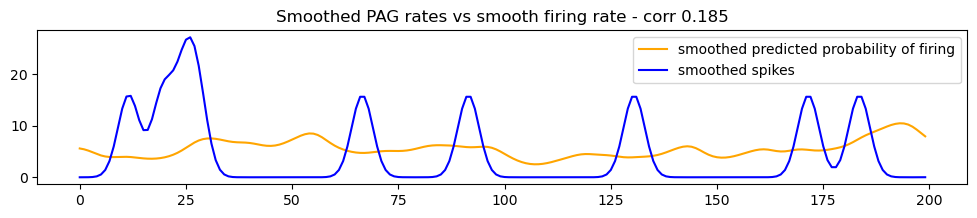

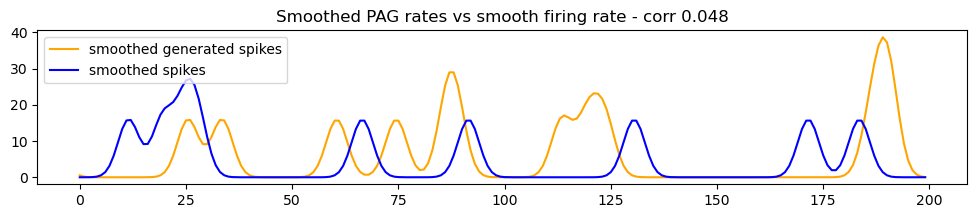

In [42]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 3 (condition 6): add Sparsity to weights

In [6]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100]),
                'weights_sparsity':100
               },
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth'))

glm.fit(X_train.T, y_train.T, n_iter=30000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg100_spars100.pth')

2023-12-14 15:34:32.443 | DEBUG    | glm:fit:315 - Training GLM with PyTorch. Initial log like: 203313.8125, loss 204167.9375, of which regs [5.4738426, 848.65063, 0.0] respectively for ['weights_within_group', 'weights_sparsity'].
2023-12-14 15:35:01.092 | DEBUG    | glm:fit:342 - Step 1500. Log like: 54376.3515625, loss 57724.15625, of which regs [198.63623, 3149.1672, 0.0] respectively for ['weights_within_group', 'weights_sparsity'].
2023-12-14 15:35:29.618 | DEBUG    | glm:fit:342 - Step 3000. Log like: 53442.46875, loss 56990.08203125, of which regs [334.28796, 3213.3247, 0.0] respectively for ['weights_within_group', 'weights_sparsity'].
2023-12-14 15:35:57.856 | DEBUG    | glm:fit:342 - Step 4500. Log like: 52915.5859375, loss 56119.2734375, of which regs [319.44806, 2884.2383, 0.0] respectively for ['weights_within_group', 'weights_sparsity'].
2023-12-14 15:36:26.123 | DEBUG    | glm:fit:342 - Step 6000. Log like: 52332.1484375, loss 55088.73828125, of which regs [304.95993, 2

In [7]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-4.4796815]
y-intercept: [0.01120994]


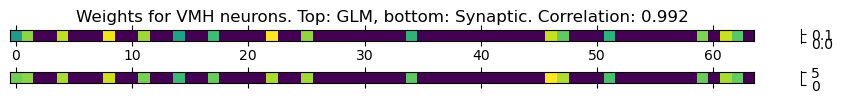

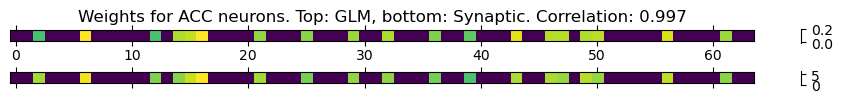

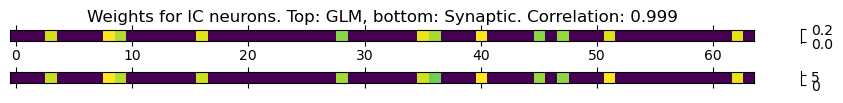

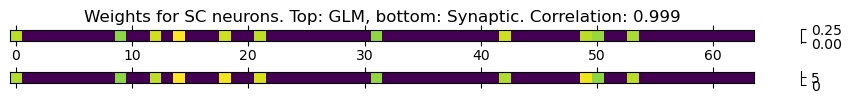

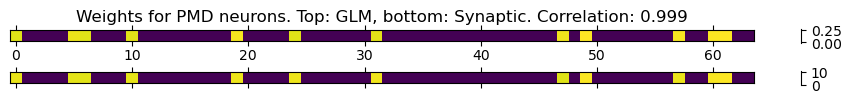

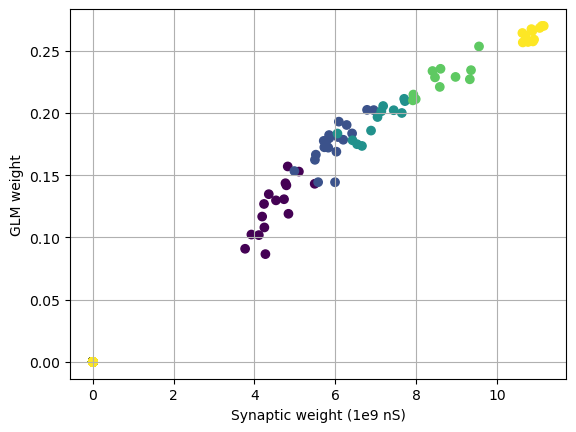

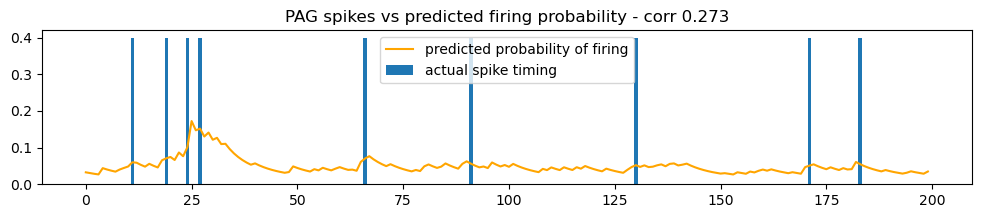

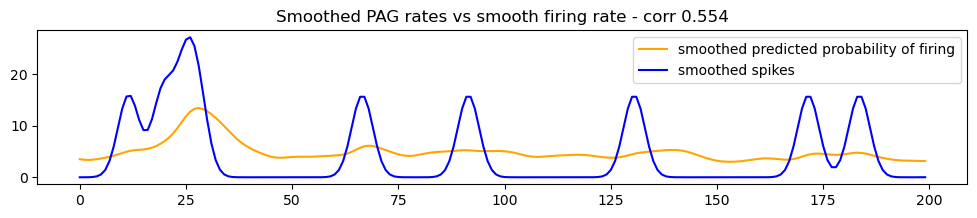

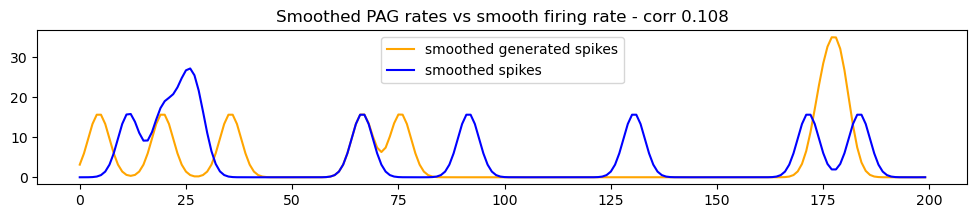

In [8]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 4: History filter alone

In [14]:
history = 10
from glm import BernoulliGLMwHistoryPyTorch
glm = BernoulliGLMwHistoryPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100])
               },
    history=history,
    ).to(device)

glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg100_history{history}.pth'))

glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.99995)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg100_history{history}.pth')

2023-12-14 16:54:59.519 | DEBUG    | glm:fit:316 - Training GLM with PyTorch. Initial log like: 43019.7890625, loss 43871.4765625, of which regs [851.68823, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:55:35.506 | DEBUG    | glm:fit:343 - Step 2000. Log like: 42859.0625, loss 43693.08203125, of which regs [834.01825, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:56:09.620 | DEBUG    | glm:fit:343 - Step 4000. Log like: 42720.484375, loss 43539.88671875, of which regs [819.4027, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:56:43.356 | DEBUG    | glm:fit:343 - Step 6000. Log like: 42602.2734375, loss 43408.8671875, of which regs [806.594, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:57:17.755 | DEBUG    | glm:fit:343 - Step 8000. Log like: 42500.06640625, loss 43295.4140625, of which regs [79

In [12]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-5.395081]
y-intercept: [0.00451834]


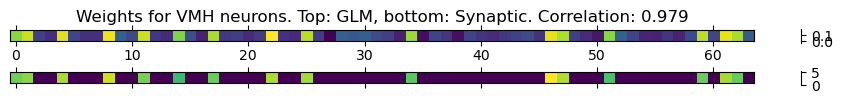

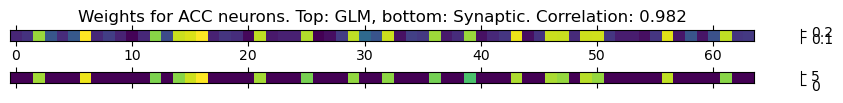

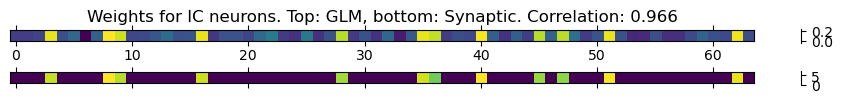

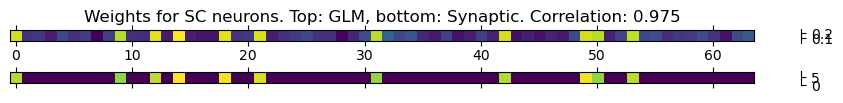

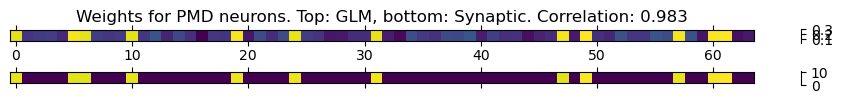

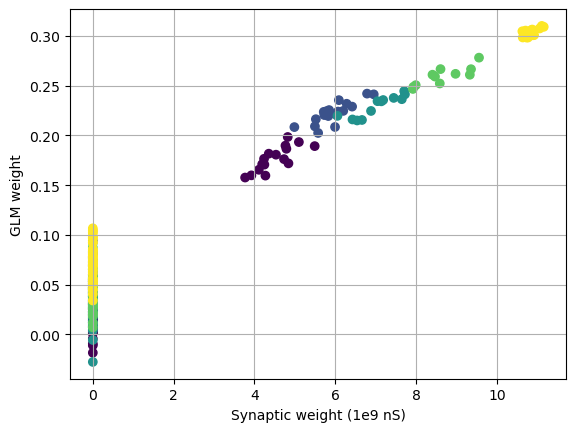

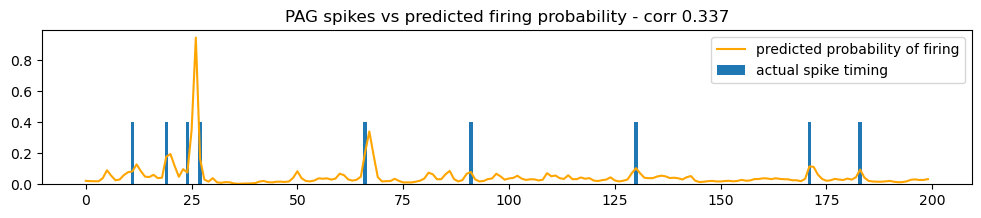

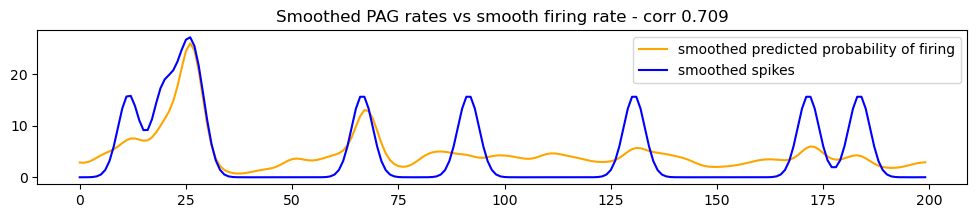

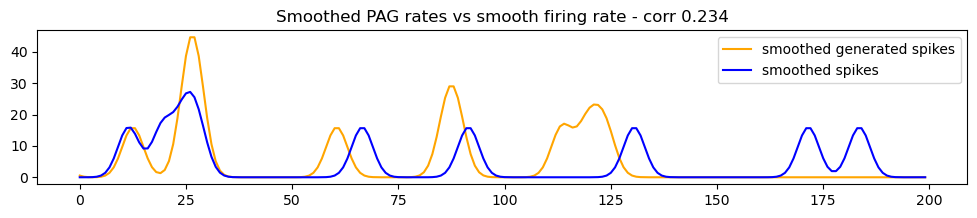

In [13]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 5: History filter + sparsity

In [7]:
history = 10
from glm import BernoulliGLMwHistoryPyTorch
glm = BernoulliGLMwHistoryPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100]),
                'weights_sparsity':100
               },
    history=history,
    ).to(device)

glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg100_sparse100_history{history}.pth'))

glm.fit(X_train.T, y_train.T, n_iter=20000, lr=1e-3, verbose=1, decay=0.99995)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg100_sparse100_history{history}.pth')

2023-12-14 16:10:59.045 | DEBUG    | glm:fit:316 - Training GLM with PyTorch. Initial log like: 47411.90625, loss 49500.82421875, of which regs [714.9713, 1373.946, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:11:17.951 | DEBUG    | glm:fit:343 - Step 1000. Log like: 47196.7734375, loss 49256.4609375, of which regs [695.12335, 1364.5625, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:11:35.953 | DEBUG    | glm:fit:343 - Step 2000. Log like: 47021.33203125, loss 49052.6640625, of which regs [677.915, 1353.4154, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:11:53.168 | DEBUG    | glm:fit:343 - Step 3000. Log like: 46869.5859375, loss 48874.96875, of which regs [661.7768, 1343.606, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:12:10.376 | DEBUG    | glm:fit:343 - Step 4000. Log like: 46733.6328125, loss 48716.398437

In [8]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-3.834742]
y-intercept: [0.02114993]


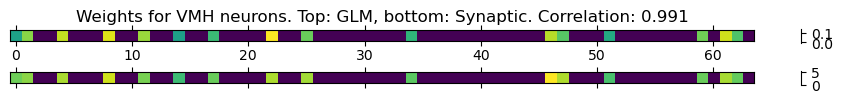

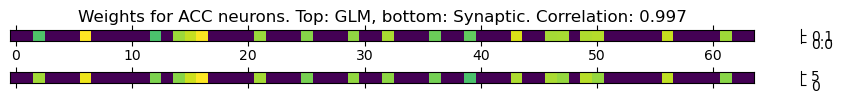

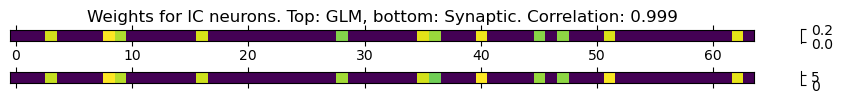

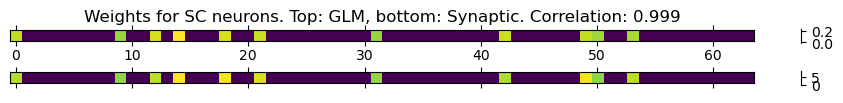

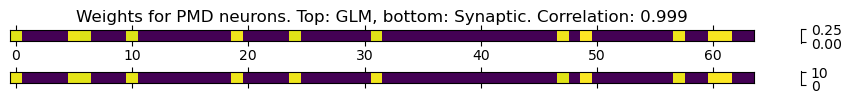

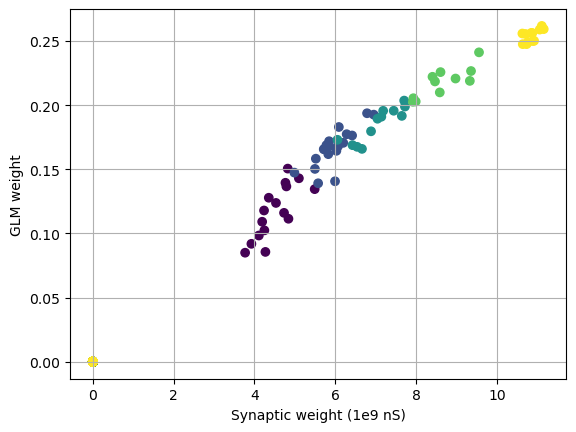

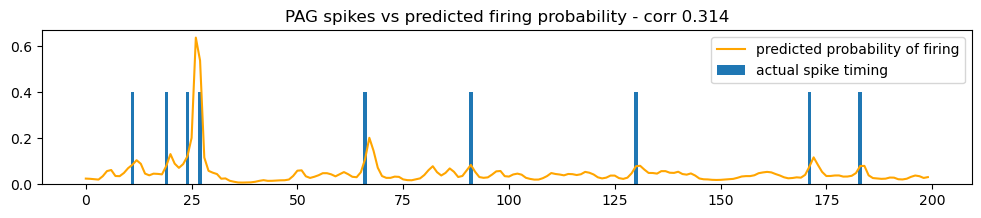

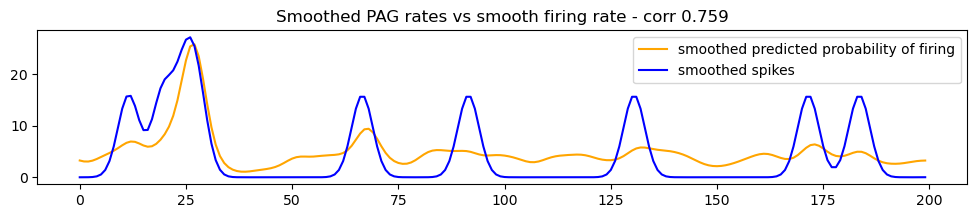

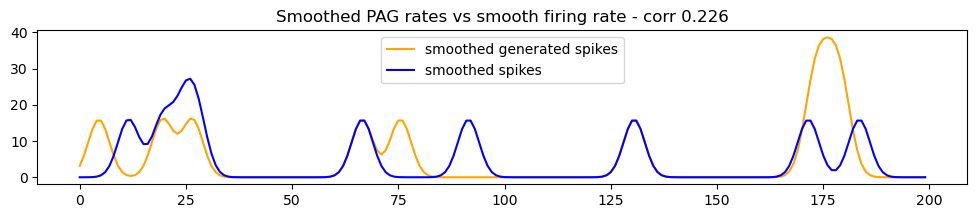

In [9]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

(array([1., 0., 1., 0., 4., 3., 0., 0., 0., 1.]),
 array([-8.28334713, -6.73482752, -5.18630791, -3.63778853, -2.08926892,
        -0.54074931,  1.0077703 ,  2.55628991,  4.10480928,  5.6533289 ,
         7.20184851]),
 <BarContainer object of 10 artists>)

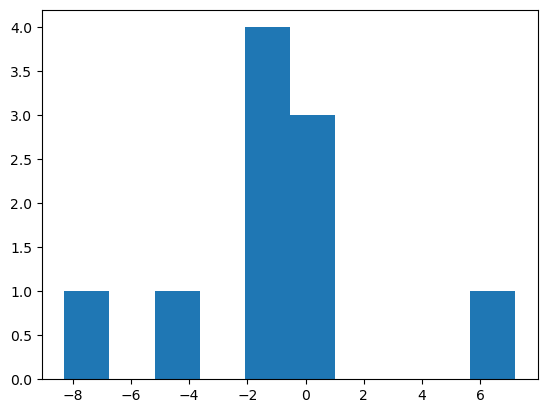

In [32]:
plt.hist(glm.history_filters.weight.data.cpu())

(array([20., 52., 72., 72., 29., 14., 17., 11., 20., 13.]),
 array([-0.19932969, -0.12045809, -0.0415865 ,  0.0372851 ,  0.1161567 ,
         0.19502831,  0.27389988,  0.35277149,  0.4316431 ,  0.51051468,
         0.58938628]),
 <BarContainer object of 10 artists>)

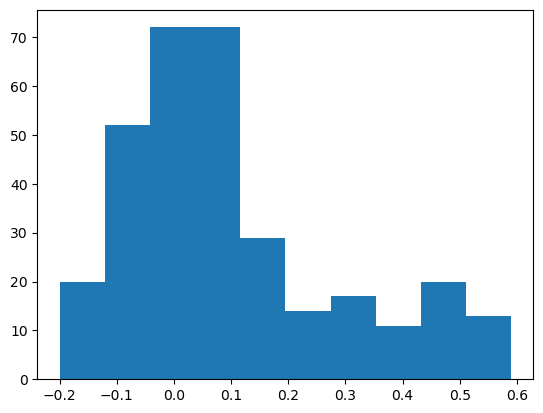

In [46]:
plt.hist(glm_w.T)

## MultiPAG case

In [8]:
class BernoulliGLMwHistoryPyTorch(BernoulliGLMPyTorch):
    def __init__(self,
                 group_names,
                 n_neurons_per_group=None,
                 synapse_origin_group=None,
                 link_fn='logistic',
                 n_sessions=1,
                 regs=['weights_within_group'],
                 reg_params=0,
                 history=1):
        
        super().__init__(group_names,
                         n_neurons_per_group=n_neurons_per_group,
                         synapse_origin_group=synapse_origin_group,
                         link_fn=link_fn,
                         n_sessions=n_sessions,
                         regs=regs,
                         reg_params=reg_params)
        
        assert isinstance(history, int) and history >= 1
        self.history = history
        self.history_filters = nn.ModuleList([nn.Linear(self.history, 1, bias=False) for _ in range(self.n_sessions)])
    
    def forward(self, X):
        '''
        Makes a forward prediction
        '''
        if isinstance(X, np.ndarray):
            X = torch.FloatTensor(X).to(device) # (bins * n_sessions, input_shape)
        
        with torch.no_grad():
            y_hat_naive = self.activation(self.linear(X)).reshape(self.n_sessions, -1, 1) # (bins * n_sessions, input_shape)
        
        y_hat_hist = torch.stack([torch.vstack([torch.zeros((self.history, 1)).to(device), y_hat_naive[c]]) for c in range(self.n_sessions)])
        hist_terms = torch.vstack(
            [self.history_filters[c](
                torch.hstack(
                    [y_hat_hist[c, h:h+int(X.shape[0]/self.n_sessions),:] for h in range(self.history)]
                )
        ) for c in range(self.n_sessions)]
        )
        
        return self.activation(self.linear(X) + hist_terms)

In [4]:
n_PAG_to_use = 8

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=bin_size)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-14 18:51:50.402 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 46.825208333333336 Hz.


In [5]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

(2560, 2400000)
Number of PAG spikes in the training set:  112056.0
Number of PAG spikes in the test set:  37146.0


In [11]:
history=3
glm = BernoulliGLMwHistoryPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100])
               },
    history=history,
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg1.pth'))

glm.fit(X_train.T, y_train.T, n_iter=25000, lr=1e-3, verbose=1, decay=0.9999)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg1.pth')
# glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg1.pth'))
print('log like:', glm.calc_log_likelihood(X_train.T, y_train.T))
print('loss: ', glm.calc_log_likelihood_w_reg(X_train.T, y_train.T))

2023-12-14 19:20:15.636 | DEBUG    | glm:fit:316 - Training GLM with PyTorch. Initial log like: 1870551.625, loss 1870558.0, of which regs [6.368554, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 07:56:27.760 | DEBUG    | glm:fit:343 - Step 1250. Log like: 455077.875, loss 459605.78125, of which regs [4527.8916, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].


KeyboardInterrupt: 

In [12]:
torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg1.pth')

Learned bias: [-0.21357241]
y-intercept: [0.44680893]


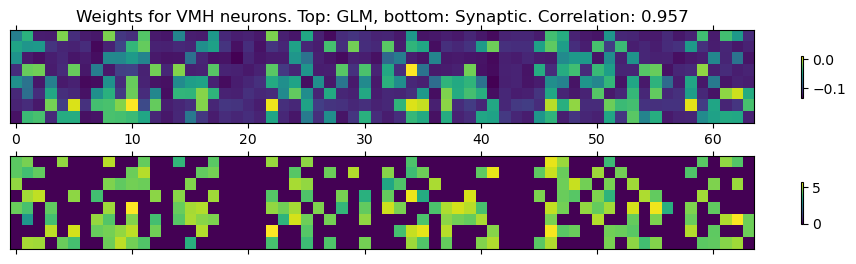

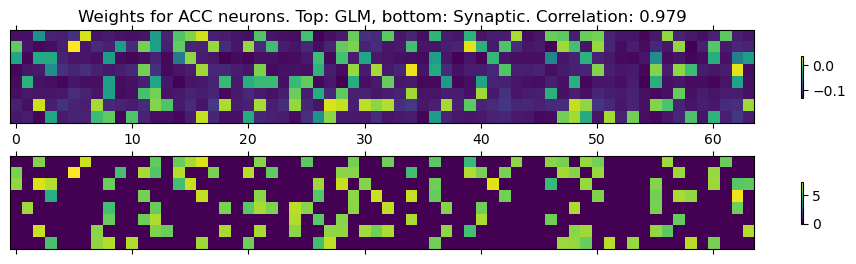

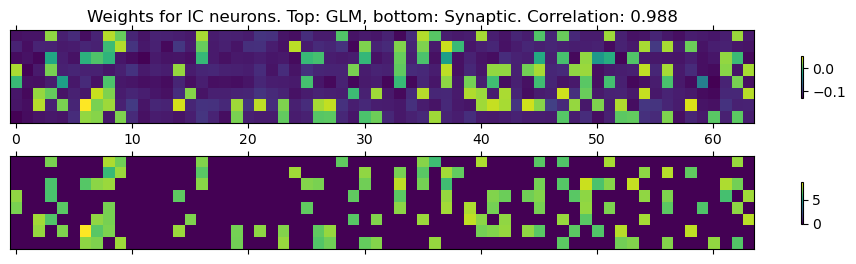

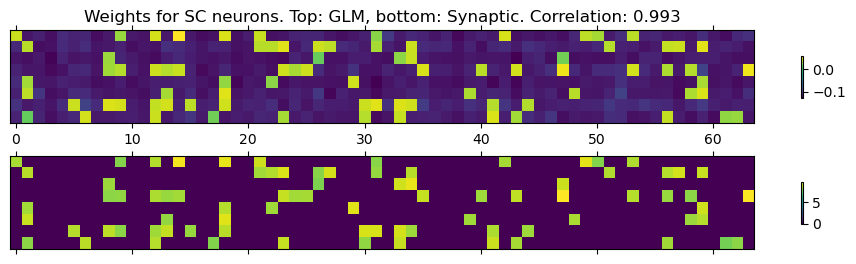

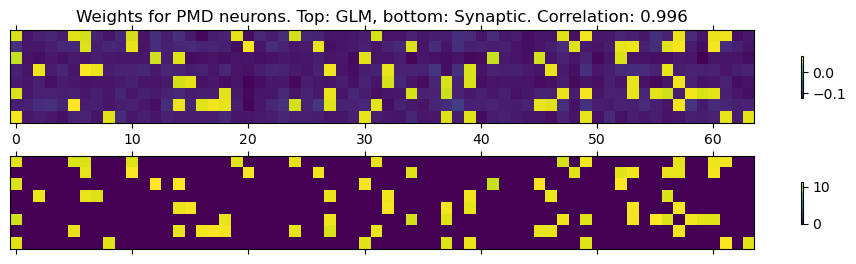

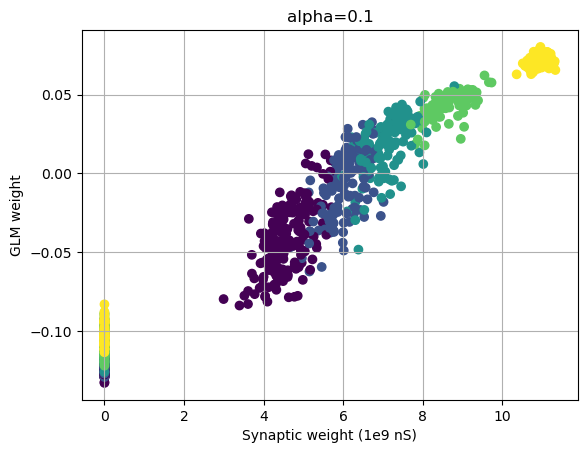

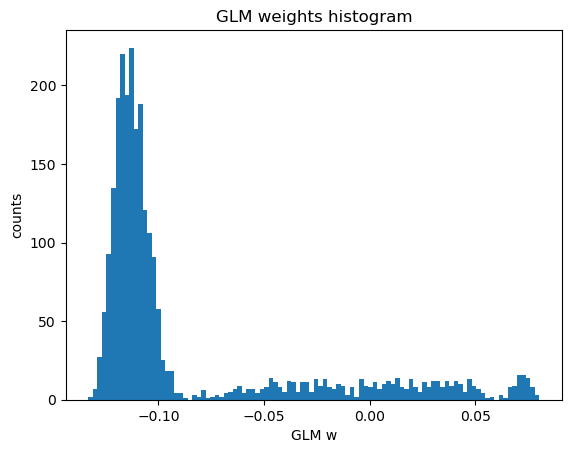

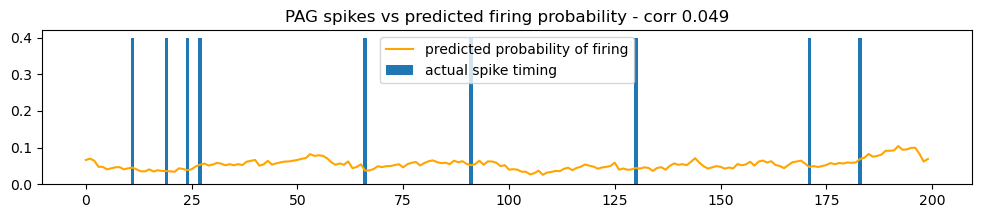

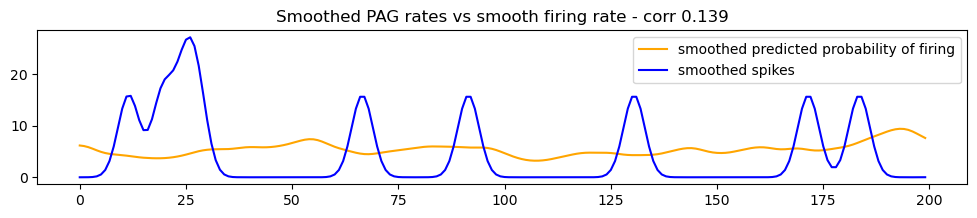

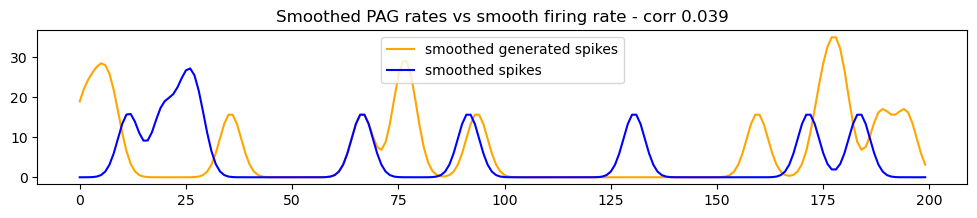

In [13]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))


# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('alpha=0.1')
plt.show()

plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    
# _range = 200 #ms
# _random_start = np.random.randint(y_test.shape[1]-_range)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()



generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()